## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007470.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008700.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_010320.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_007170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_006690_P.png')]

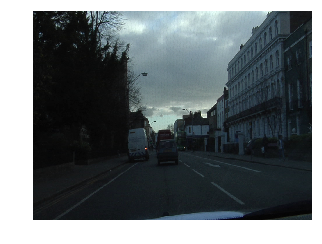

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

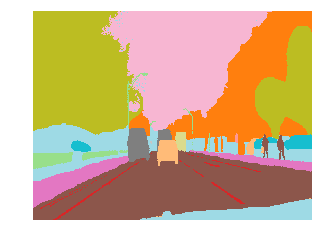

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

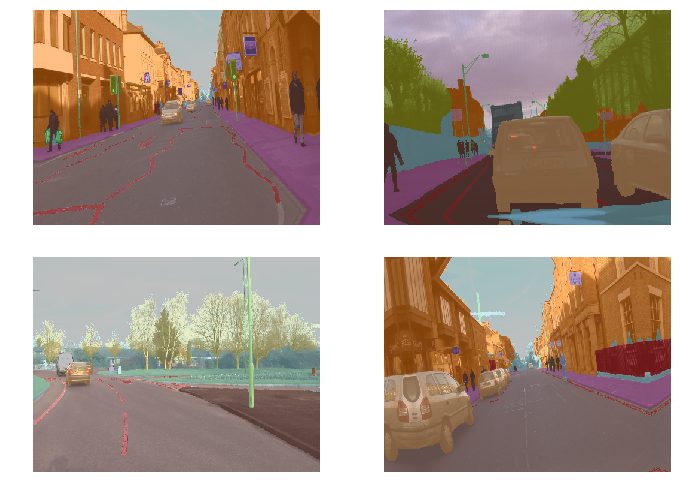

In [15]:
data.show_batch(2, figsize=(10,7))

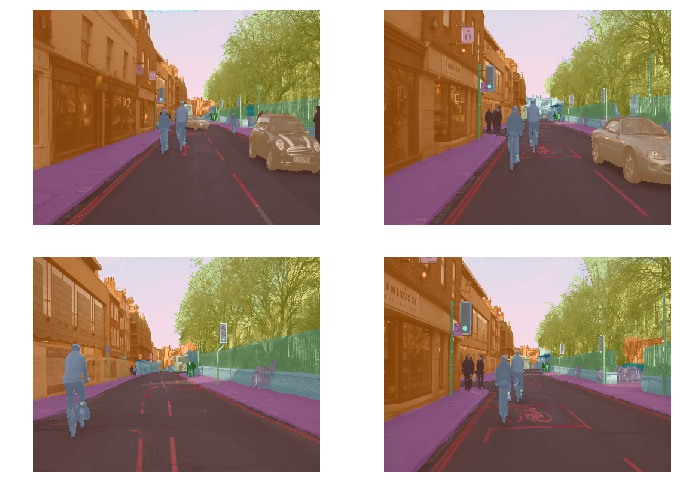

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


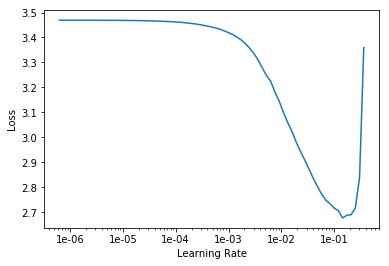

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=1e-2

In [22]:
learn.fit_one_cycle(10, slice(lr))

Total time: 05:05
epoch  train_loss  valid_loss  acc_camvid
1      1.545136    0.887107    0.823114    (00:33)
2      0.902223    0.631133    0.832146    (00:29)
3      0.720033    0.803365    0.792290    (00:29)
4      0.659755    0.516642    0.859368    (00:30)
5      0.599339    0.456135    0.872972    (00:30)
6      0.564234    0.474756    0.866432    (00:30)
7      0.508940    0.381676    0.890038    (00:30)
8      0.460250    0.370738    0.888537    (00:30)
9      0.428263    0.358563    0.892382    (00:30)
10     0.409316    0.353921    0.891979    (00:30)



In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

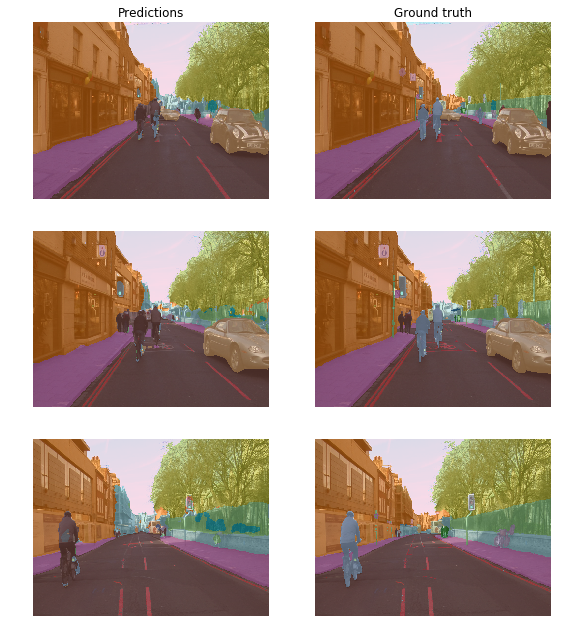

In [25]:
learn.show_results()

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


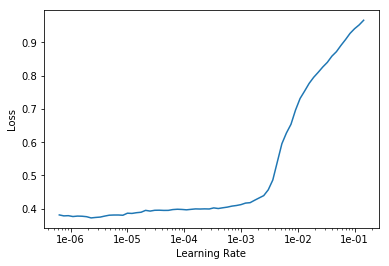

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lrs = slice(1e-5,lr/5)

In [29]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.403908,0.353318,0.891281


RuntimeError: CUDA error: out of memory

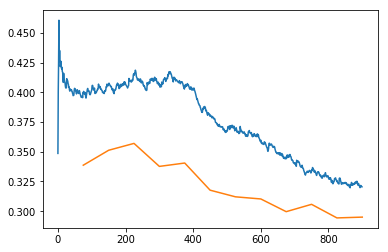

In [ ]:
learn.recorder.plot_losses()

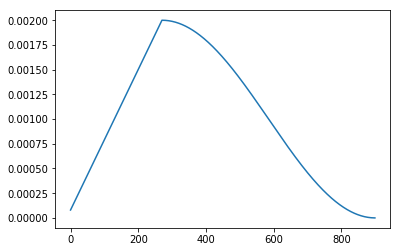

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


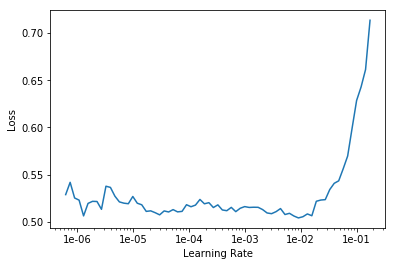

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:44
epoch  train_loss  valid_loss  acc_camvid
1      0.454597    0.349557    0.900428    (01:02)
2      0.418897    0.351502    0.897495    (00:51)
3      0.402104    0.330255    0.906775    (00:50)
4      0.385497    0.313330    0.911832    (00:51)
5      0.359252    0.297264    0.916108    (00:52)
6      0.335910    0.297875    0.917553    (00:50)
7      0.336133    0.305602    0.913439    (00:51)
8      0.321016    0.305374    0.914063    (00:51)
9      0.311554    0.299226    0.915997    (00:51)
10     0.308389    0.301060    0.915253    (00:51)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

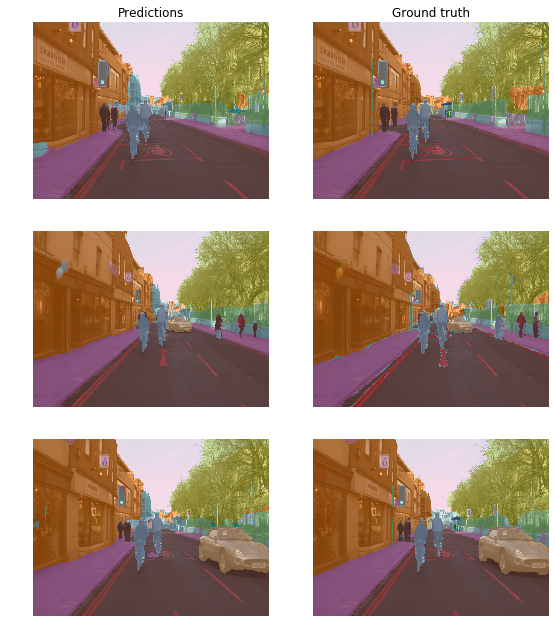

In [ ]:
learn.show_results()